In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 29.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import seaborn as sns
import re
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import style
style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
stemmer = nltk.SnowballStemmer ("english")
from sklearn.svm import SVC
import emoji
import pickle
import joblib

In [4]:
df = pd.read_csv("/content/drive/MyDrive/pemrosesan teks/pemrosesan teks/twitter_data.csv")
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [5]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = emoji.demojize(text, language='en')
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    text = re.sub(r'(\w)\1+', r'\1', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text
df1 = df["tweet"].apply(clean)
df["tweet"]=df1
df = df.drop(['Unnamed: 0', 'count'], axis=1)
df = df.drop_duplicates('tweet')
df.head()

,hate_speech,offensive_language,neither,class,tweet
0,0,0,3,2,rt mayasolov as a woman you shouldnt complain...
1,0,3,0,1,rt boy dat coldtyga dwn bad for cufin dat ho...
2,0,3,0,1,rt urkindofbrand dawg rt you ever fuck a bit...
3,0,2,1,1,rt cganderson vivabas she lok like a trani
4,0,6,0,1,rt shenikarobert the shit you hear about me m...


In [6]:
tfidf_model = TfidfVectorizer(ngram_range=(0, 2))

vect2 = tfidf_model.fit(df['tweet'])

x = df['tweet']
Y = df['class']
X = vect2.transform(x)

# Membagi dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=123)

# Menampilkan bentuk (shape) dari data
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Menampilkan jumlah setiap kelas pada data y_test
class_counts = pd.Series(y_test).value_counts()
print("\nJumlah setiap kelas pada data test:")
print(class_counts)

Shape of x_train: (20951, 165288)
Shape of x_test: (3698, 165288)
Shape of y_train: (20951,)
Shape of y_test: (3698,)

Jumlah setiap kelas pada data test:
class
1    2875
2     608
0     215
Name: count, dtype: int64


In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={2:5000, 0:3220}, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
y_train_resampled.value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


,count
class,
1,16232
2,5000
0,3220


In [8]:
from imblearn.under_sampling import RandomUnderSampler

# Membuat objek RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={1:8000}, random_state=123)

# Melakukan undersampling pada data latih
X_train_resampled1, y_train_resampled1 = undersampler.fit_resample(X_train_resampled,  y_train_resampled)

# Menampilkan jumlah masing-masing kelas setelah undersampling
y_train_resampled1.value_counts()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


,count
class,
1,8000
2,5000
0,3220


In [9]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


[I 2025-01-05 14:08:25,570] A new study created in memory with name: no-name-cfe6dccd-648f-4f99-961b-b8f3c546a071
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
<ipython-input-12-8bda73679813>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47796
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 1100
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:08:44,668] Trial 0 finished with value: 0.84559221200649 and parameters: {'n_estimators': 650, 'max_depth': 3, 'learning_rate': 0.007565605551745233, 'num_leaves': 76, 'subsample': 0.887206440260651, 'colsample_bytree': 0.9038575397754107, 'min_child_samples': 32, 'scale_pos_weight': 2.2970360682792847}. Best is trial 0 with value: 0.84559221200649.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be re

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35794
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 403
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:09:22,642] Trial 1 finished with value: 0.7774472687939427 and parameters: {'n_estimators': 943, 'max_depth': 7, 'learning_rate': 1.523606466367557e-05, 'num_leaves': 127, 'subsample': 0.7331498952086346, 'colsample_bytree': 0.6780323998598108, 'min_child_samples': 80, 'scale_pos_weight': 1.1632104823448601}. Best is trial 0 with value: 0.84559221200649.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35307
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 386
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:09:46,087] Trial 2 finished with value: 0.8493780421849648 and parameters: {'n_estimators': 733, 'max_depth': 7, 'learning_rate': 0.0007468975972072088, 'num_leaves': 223, 'subsample': 0.936374623475951, 'colsample_bytree': 0.9318376904477654, 'min_child_samples': 85, 'scale_pos_weight': 8.741386859377567}. Best is trial 2 with value: 0.8493780421849648.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34080
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 347
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:09:52,196] Trial 3 finished with value: 0.8704705246078962 and parameters: {'n_estimators': 118, 'max_depth': 10, 'learning_rate': 0.05803593527471229, 'num_leaves': 256, 'subsample': 0.8623513292789444, 'colsample_bytree': 0.7233503599560014, 'min_child_samples': 96, 'scale_pos_weight': 7.566427258210251}. Best is trial 3 with value: 0.8704705246078962.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51742
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 1472
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:10:06,984] Trial 4 finished with value: 0.8318009734991888 and parameters: {'n_estimators': 984, 'max_depth': 2, 'learning_rate': 0.005761068137813663, 'num_leaves': 93, 'subsample': 0.8648693853727101, 'colsample_bytree': 0.9033871598914264, 'min_child_samples': 25, 'scale_pos_weight': 7.610431138545728}. Best is trial 3 with value: 0.8704705246078962.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will b

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41390
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 655
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:10:26,159] Trial 5 finished with value: 0.7774472687939427 and parameters: {'n_estimators': 632, 'max_depth': 5, 'learning_rate': 0.00016283501520279812, 'num_leaves': 129, 'subsample': 0.6145106521670199, 'colsample_bytree': 0.9986842492083197, 'min_child_samples': 51, 'scale_pos_weight': 4.41002515042762}. Best is trial 3 with value: 0.8704705246078962.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35188
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 382
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:10:47,504] Trial 6 finished with value: 0.8601946998377501 and parameters: {'n_estimators': 552, 'max_depth': 8, 'learning_rate': 0.0005860984273838416, 'num_leaves': 125, 'subsample': 0.8722436210344704, 'colsample_bytree': 0.9879749394108946, 'min_child_samples': 86, 'scale_pos_weight': 5.304383477159629}. Best is trial 3 with value: 0.8704705246078962.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.033304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66519
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 3759
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:11:13,990] Trial 7 finished with value: 0.7774472687939427 and parameters: {'n_estimators': 440, 'max_depth': 5, 'learning_rate': 1.2326292054077896e-05, 'num_leaves': 253, 'subsample': 0.894434697046254, 'colsample_bytree': 0.7053463778903852, 'min_child_samples': 11, 'scale_pos_weight': 5.234484299720082}. Best is trial 3 with value: 0.8704705246078962.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34820
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 370
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:11:16,659] Trial 8 finished with value: 0.819902650081125 and parameters: {'n_estimators': 168, 'max_depth': 2, 'learning_rate': 0.0209017522353586, 'num_leaves': 142, 'subsample': 0.6116711171075142, 'colsample_bytree': 0.9084402000013712, 'min_child_samples': 90, 'scale_pos_weight': 6.876585326191593}. Best is trial 3 with value: 0.8704705246078962.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45070
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 890
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:11:39,025] Trial 9 finished with value: 0.7774472687939427 and parameters: {'n_estimators': 603, 'max_depth': 8, 'learning_rate': 0.0002245920489556229, 'num_leaves': 17, 'subsample': 0.6340456516525033, 'colsample_bytree': 0.9443461788997489, 'min_child_samples': 39, 'scale_pos_weight': 7.2863179987514055}. Best is trial 3 with value: 0.8704705246078962.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37956
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 487
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:12:03,488] Trial 10 finished with value: 0.8758788534342888 and parameters: {'n_estimators': 147, 'max_depth': -1, 'learning_rate': 0.0886923627381018, 'num_leaves': 206, 'subsample': 0.7682308499445928, 'colsample_bytree': 0.7821373098560743, 'min_child_samples': 67, 'scale_pos_weight': 9.99758095191536}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37956
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 487
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:12:27,245] Trial 11 finished with value: 0.8729042725797729 and parameters: {'n_estimators': 133, 'max_depth': -1, 'learning_rate': 0.09908233606913665, 'num_leaves': 213, 'subsample': 0.7729008004605997, 'colsample_bytree': 0.774902564099971, 'min_child_samples': 67, 'scale_pos_weight': 9.861041134836293}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37956
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 487
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:13:17,802] Trial 12 finished with value: 0.8734451054624122 and parameters: {'n_estimators': 301, 'max_depth': -1, 'learning_rate': 0.08765794714523967, 'num_leaves': 189, 'subsample': 0.7606875506248884, 'colsample_bytree': 0.7992121590341446, 'min_child_samples': 67, 'scale_pos_weight': 9.923373429310091}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature wil

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38439
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 508
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:13:59,220] Trial 13 finished with value: 0.8715521903731747 and parameters: {'n_estimators': 326, 'max_depth': -1, 'learning_rate': 0.00531284945455122, 'num_leaves': 186, 'subsample': 0.7112767596111931, 'colsample_bytree': 0.6113210095717337, 'min_child_samples': 64, 'scale_pos_weight': 9.90475535065349}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37644
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 474
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:14:46,054] Trial 14 finished with value: 0.8723634396971336 and parameters: {'n_estimators': 306, 'max_depth': 0, 'learning_rate': 0.021975229413710266, 'num_leaves': 191, 'subsample': 0.8006786758731396, 'colsample_bytree': 0.8295854478855036, 'min_child_samples': 69, 'scale_pos_weight': 9.137576826298957}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature wil

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41390
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 655
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:14:49,152] Trial 15 finished with value: 0.8153055705786911 and parameters: {'n_estimators': 283, 'max_depth': 1, 'learning_rate': 0.024187127920056853, 'num_leaves': 174, 'subsample': 0.9970236695923472, 'colsample_bytree': 0.8167083072632938, 'min_child_samples': 51, 'scale_pos_weight': 8.763989560508882}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature wil

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37103
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 452
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:15:51,187] Trial 16 finished with value: 0.8718226068144943 and parameters: {'n_estimators': 425, 'max_depth': 0, 'learning_rate': 0.09945119204589238, 'num_leaves': 167, 'subsample': 0.6971439288249772, 'colsample_bytree': 0.775367878308922, 'min_child_samples': 72, 'scale_pos_weight': 6.254611903359857}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39889
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 576
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:15:56,741] Trial 17 finished with value: 0.8090859924283397 and parameters: {'n_estimators': 238, 'max_depth': 3, 'learning_rate': 0.002969278371147542, 'num_leaves': 214, 'subsample': 0.8034213507389758, 'colsample_bytree': 0.8312788230355181, 'min_child_samples': 57, 'scale_pos_weight': 3.47472921333116}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36291
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 421
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:17:01,148] Trial 18 finished with value: 0.8750676041103299 and parameters: {'n_estimators': 427, 'max_depth': -1, 'learning_rate': 0.023733817655222523, 'num_leaves': 231, 'subsample': 0.6768407632315616, 'colsample_bytree': 0.8570740791296662, 'min_child_samples': 78, 'scale_pos_weight': 8.537884631102175}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature wi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36372
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 424
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:17:05,072] Trial 19 finished with value: 0.8307193077339102 and parameters: {'n_estimators': 440, 'max_depth': 1, 'learning_rate': 0.027240585862773017, 'num_leaves': 231, 'subsample': 0.6687510362761899, 'colsample_bytree': 0.8617627628734196, 'min_child_samples': 77, 'scale_pos_weight': 8.425101234144732}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature wil

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34014
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 345
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:17:20,611] Trial 20 finished with value: 0.8277447268793943 and parameters: {'n_estimators': 857, 'max_depth': 4, 'learning_rate': 0.0018331653938240143, 'num_leaves': 14, 'subsample': 0.6757823600433126, 'colsample_bytree': 0.7469822559028698, 'min_child_samples': 97, 'scale_pos_weight': 6.231034633961377}. Best is trial 10 with value: 0.8758788534342888.
<ipython-input-12-8bda73679813>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-12-8bda73679813>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature wil

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38967
[LightGBM] [Info] Number of data points in the train set: 16220, number of used features: 532
[LightGBM] [Info] Start training from score -1.616864
[LightGBM] [Info] Start training from score -0.706804
[LightGBM] [Info] Start training from score -1.176807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-05 14:18:32,225] Trial 21 finished with value: 0.8761492698756085 and parameters: {'n_estimators': 385, 'max_depth': -1, 'learning_rate': 0.0455795855621183, 'num_leaves': 200, 'subsample': 0.7506768308568419, 'colsample_bytree': 0.860079777876006, 'min_child_samples': 62, 'scale_pos_weight': 9.889556897783681}. Best is trial 21 with value: 0.8761492698756085.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best trial: FrozenTrial(number=21, state=TrialState.COMPLETE, values=[0.8761492698756085], datetime_start=datetime.datetime(2025, 1, 5, 14, 17, 20, 613140), datetime_complete=datetime.datetime(2025, 1, 5, 14, 18, 32, 224656), params={'n_estimators': 385, 'max_depth': -1, 'learning_rate': 0.0455795855621183, 'num_leaves': 200, 'subsample': 0.7506768308568419, 'colsample_bytree': 0.860079777876006, 'min_child_samples': 62, 'scale_pos_weight': 9.889556897783681}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=-1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'min_child_samples': IntDist

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.43      0.44      0.43       215
           1       0.96      0.90      0.93      2875
           2       0.72      0.94      0.81       608

    accuracy                           0.88      3698
   macro avg       0.70      0.76      0.72      3698
weighted avg       0.89      0.88      0.88      3698

Test accuracy: 87.61%


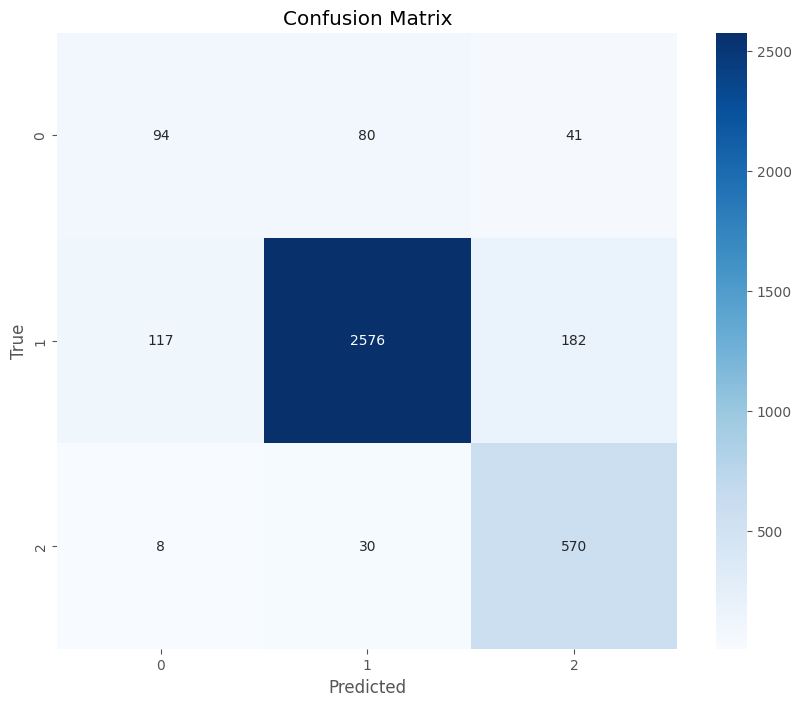

In [12]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Fungsi untuk mengevaluasi model dengan hyperparameter tertentu
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0)
    }

    model = lgb.LGBMClassifier(**param, random_state=123)
    model.fit(X_train_resampled1, y_train_resampled1)

    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


# Membuat studi Optuna untuk mencari hyperparameter terbaik
study = optuna.create_study(direction='maximize')  # Maksimalkan akurasi
study.optimize(objective, n_trials=100, timeout=600)  # Lakukan pencarian 100 percobaan atau 600 detik

# Tampilkan hasil terbaik
print(f"Best trial: {study.best_trial}")
print(f"Best hyperparameters: {study.best_trial.params}")

# Evaluasi model terbaik
best_params = study.best_trial.params
best_model = lgb.LGBMClassifier(**best_params, random_state=123)
best_model.fit(X_train_resampled1, y_train_resampled1)

# Prediksi menggunakan model terbaik
best_predict = best_model.predict(x_test)

# Hitung akurasi
best_acc = accuracy_score(y_test, best_predict)
print(classification_report(y_test, best_predict))
print("Test accuracy: {:.2f}%".format(best_acc * 100))

# Matriks kebingungan (Confusion Matrix)
cm_best = confusion_matrix(y_test, best_predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [13]:
import pickle

# Simpan model terbaik ke file pickle
model_filename = 'best_lightgbm_model1.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model terbaik telah disimpan dengan nama file '{model_filename}'.")


Model terbaik telah disimpan dengan nama file 'best_lightgbm_model1.pkl'.


In [ ]:
# Simpan model setelah melatih model
model_filename = 'svm_model.pkl'
joblib.dump(svm_model, model_filename)
print(f"Model berhasil disimpan sebagai {model_filename}")

# Simpan model TF-IDF ke dalam file
tfidf_model_filename = 'tfidf_model.pkl'
joblib.dump(tfidf_model, tfidf_model_filename)
print(f"Model TF-IDF berhasil disimpan sebagai {tfidf_model_filename}")

Model berhasil disimpan sebagai svm_model.pkl


In [ ]:
# Simpan model setelah melatih model
model_filename = 'svm_modelnew.sav'
pickle.dump(svm_model, open(model_filename, 'wb'))
print(f"Model berhasil disimpan sebagai {model_filename}")

# Simpan model TF-IDF ke dalam file
tfidf_model_filename = 'tfidf_model.sav'
pickle.dump(tfidf_model, open(tfidf_model_filename,'wb'))
print(f"Model TF-IDF berhasil disimpan sebagai {tfidf_model_filename}")

Model berhasil disimpan sebagai svm_modelnew.sav
